Preprocessing

1. Extract Data. (Use Petter's Code)

2. Crop the data to full days (Petter has code)

3. Extract days to match the days in the scores csv.
(A csv file exists if you wish to skip these steps)



In [1]:
# Import modules

import os
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import seaborn as sns
from datetime import date, timedelta
from matplotlib import pyplot as plt
from scipy.stats import skew

In [2]:
# Petter's code for extracting all the data files and then combining them.

def extract_folder(folderpath, add_scores=False, downsample=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): Path to the folder containing CSV files.
      add_scores (bool, optional): Boolean to add scores.csv to the dataframe. Defaults to False.
      downsample (int, optional): Number of rows to downsample CSVs to. Defaults to None.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # Dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # Handle top-level scores CSV
        if add_scores and 'scores.csv' in os.listdir(folderpath):
            scores_path = os.path.join(folderpath, 'scores.csv')  
            dfs['scores'] = pd.read_csv(scores_path)

        # Get subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # Get list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # Extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # Downsample if needed
                if downsample:
                    df = df.sample(downsample)

                # Add ID column - this is the filename without the extension
                df['id'] = id

                # Add 'condition' column
                df['condition'] = subfolder

                # Convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # Append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # Reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)

    # Final concat
    return df

In [3]:
# Extration of all the acitvity data into one data frame

df = extract_folder('../data/depresjon')
df.shape


(1571706, 5)

In [4]:
df.head()

,timestamp,date,activity,id,label
0,2003-03-18 15:00:00,2003-03-18,60,control_1,0
1,2003-03-18 15:01:00,2003-03-18,0,control_1,0
2,2003-03-18 15:02:00,2003-03-18,264,control_1,0
3,2003-03-18 15:03:00,2003-03-18,662,control_1,0
4,2003-03-18 15:04:00,2003-03-18,293,control_1,0


In [5]:
control_1 = df[df['id'] == "control_1"]

In [6]:
def fullDays(dataframe):
    participants = dataframe['id'].unique()
    df_new = pd.DataFrame({})
    for participant in participants:
        df_tochange = dataframe[dataframe['id'] == participant]
        min_timestamp = df_tochange['timestamp'].min()
        min_date = df_tochange['date'].min()
        
        if min_date < min_timestamp:
            min_fullday_date = min_date + timedelta(1)
            df_minchange = df_tochange[df_tochange['date'] >= min_fullday_date]
        else:
            df_minchange = df_tochange.copy()
        
        max_timestamp = df_minchange['timestamp'].max()
        max_date = df_minchange['date'].max()
        
        if max_date < max_timestamp:
            df_maxchange = df_minchange[df_minchange['date'] < max_date]
        else:
            df_maxchange = df_minchange.copy()
        
        df_new = pd.concat([df_new,df_maxchange])
        
    return (df_new)

fulldays_df = fullDays(df)

In [7]:
fulldays_df.head()

,timestamp,date,activity,id,label
540,2003-03-19 00:00:00,2003-03-19,0,control_1,0
541,2003-03-19 00:01:00,2003-03-19,0,control_1,0
542,2003-03-19 00:02:00,2003-03-19,0,control_1,0
543,2003-03-19 00:03:00,2003-03-19,0,control_1,0
544,2003-03-19 00:04:00,2003-03-19,175,control_1,0


In [8]:
print(fulldays_df.loc[fulldays_df['id'] == 'condition_1', 'date'].max() - 
fulldays_df.loc[fulldays_df['id'] == 'condition_1', 'date'].min())

14 days 00:00:00


In [9]:
scores = pd.read_csv('data/depresjon/scores.csv')
scores.head()

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [10]:
def trueDates (dataframe):
    df_new = pd.DataFrame({})
    participants = dataframe['id'].unique()
    for participant in participants:
        df_tochange = dataframe[dataframe['id'] == participant]
        trueDays = scores.loc[scores['number'] == participant, 'days'].values[0]
        min_date = dataframe.loc[dataframe['id'] == participant, 'date'].min()
        min_truedate = min_date + timedelta(int(trueDays))
        df_reduce = df_tochange[df_tochange['date'] < min_truedate]
        df_new = pd.concat([df_new,df_reduce])
    return (df_new)
trueDates(fulldays_df)

,timestamp,date,activity,id,label
540,2003-03-19 00:00:00,2003-03-19,0,control_1,0
541,2003-03-19 00:01:00,2003-03-19,0,control_1,0
542,2003-03-19 00:02:00,2003-03-19,0,control_1,0
543,2003-03-19 00:03:00,2003-03-19,0,control_1,0
544,2003-03-19 00:04:00,2003-03-19,175,control_1,0
...,...,...,...,...,...
1570793,2004-06-09 23:55:00,2004-06-09,169,condition_9,1
1570794,2004-06-09 23:56:00,2004-06-09,169,condition_9,1
1570795,2004-06-09 23:57:00,2004-06-09,169,condition_9,1
1570796,2004-06-09 23:58:00,2004-06-09,169,condition_9,1


In [11]:
scores.loc[scores['number'] == 'condition_1', 'days'].values[0]

11

EDA

1. You may wish to do some EDA here. What unique insights can you come up with?

<Axes: xlabel='timestamp', ylabel='activity'>

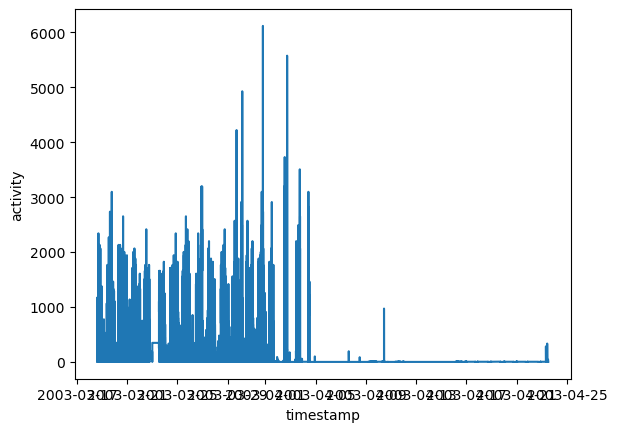

In [12]:
sns.lineplot(data = control_1, x='timestamp', y='activity')

Feature Extraction 

1. Produce a pandas dataframe which has these columns:

    - label (1s and 0s identifying condition and control)
    - Gender (1's female and 2's for male)
    - mean
    - percentage of zero activity
    - standard deviation

2. Create 3 Subsets, male, female and everyone.

In [13]:
# Rename the number column to "id" matching the data frames title
scores.rename(columns={'number':'id'}, inplace=True)

# merge data frames to add the gender column
merged_df = pd.merge(fulldays_df, scores, on='id')

# remove unused columns
merged_df.drop(['days','age','afftype','melanch','inpatient','edu','marriage','work','madrs1','madrs2'], axis=1, inplace=True)

In [14]:
# check column headers

merged_df.head(5)

,timestamp,date,activity,id,label,gender
0,2003-03-19 00:00:00,2003-03-19,0,control_1,0,2
1,2003-03-19 00:01:00,2003-03-19,0,control_1,0,2
2,2003-03-19 00:02:00,2003-03-19,0,control_1,0,2
3,2003-03-19 00:03:00,2003-03-19,0,control_1,0,2
4,2003-03-19 00:04:00,2003-03-19,175,control_1,0,2


In [15]:
# create a csv file for the merged data to check

csv_file = 'merged_df.csv'
merged_df.to_csv(csv_file, index=False)

In [16]:
def Percentzero (values):
    zeros = (values == 0).sum().sum()
    total_values = values.size
    return zeros / total_values * 100

# create a function to produce a table of features listed above

def extract_features(dataframe):
    
    # Group by 'id' and 'label' columns
    grouped = dataframe.groupby(['id', 'label','gender'])['activity']

    # Calculate statistics for 'standardised_activity' within each group
    features1_df = pd.DataFrame({
        'mean' : grouped.mean(),
        'std' : grouped.std(),
        '%zero': grouped.apply(Percentzero)
    })

    return features1_df
    
features = extract_features(merged_df).reset_index()

In [17]:
# Drop the id column
features.drop('id', axis=1, inplace=True)

# Create the 3 subsets

male_df = features[features['gender'] == 2]
female_df = features[features['gender'] == 1]
all_df = features.copy()

In [18]:
male_df.head()

,label,gender,mean,std,%zero
0,1,2,152.199630,300.785063,45.583333
1,1,2,296.403373,409.994798,35.084325
3,1,2,152.202579,268.472068,43.427579
4,1,2,220.811029,347.516571,43.165850
6,1,2,110.199752,233.995667,51.165675


Model

1. Create Train Test arrays

2. Use the following models:
    - Decision Tree
    - Random forest
    - KNN
    - Naive Bayes
    - Logistic Regression
    - Linear SVM (Not done in ML)
    - RBF (Not done in ML)
    - Gaussian Process (Not done in ML)
    - Neural Network (Not done in ML)
    - AdaBoost (Not done in ML)
    - QDA (Not done in ML)
    - ZeroR baseline (Not done in ML)
    - Linear Regression (Not done in ML)
    - XGBoost (Not done in ML)
    - Light GBM (Not done in ML)
    - GradientBoost (Not done in ML)

Measures of accuracy

1. Produce a table with the follwoing measures
- True Positive
- True Negative
- False Positive
- False Negative
- Sensitivity
- Specificity
- Predictive Value (PPV)
- Negative Predicted Value
- Accuracy
- F1 
- Recall

2. Produce a Confusion Matrix

In [55]:
# Load ML modules

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


In [56]:
def print_metrics(pred,test):
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    true_positive = ((pred == 1) & (test == 1)).sum()
    true_negative = ((pred == 0) & (test == 0)).sum()
    false_positive = ((pred == 1) & (test == 0)).sum()
    false_negative = ((pred == 0) & (test == 1)).sum()

    # Calculate additional metrics
    if true_positive + false_negative == 0:
        sensitivity = "NaN"
    else:
        sensitivity = true_positive / (true_positive + false_negative)
    
    if true_negative + false_positive == 0:
        specificity = "NaN"
    else:
        specificity = true_negative / (true_negative + false_positive)

    if true_positive + false_positive == 0:
        ppv = "NaN"
    else:
        ppv = true_positive / (true_positive + false_positive)
    
    if true_negative + false_negative == 0:
        npv = "NaN"
    else:
        npv = true_negative / (true_negative + false_negative)
    
    if true_positive + true_negative + false_positive + false_negative == 0:
        accuracy = "NaN"
    else:
        accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative) 
    

    # Create a DataFrame
    results_df = pd.DataFrame({
        'Metric': ['Accuracy', 'True Positive','True Negative', 'False Positive', 'False Negative', 
                   'Sensitivity', 'Specificity', 'Predictive Value (PPV)', 
                   'Negative Predicted Value'],
        'Value': [accuracy, true_positive, true_negative, false_positive, false_negative, 
                  sensitivity, specificity, ppv, npv]
    })

    # Display the DataFrame
    print(results_df)

In [66]:
def run_ml_algorithms(data,color):
    
    X = data.iloc[:, 1:]  # Features (train data)
    y = data.iloc[:, 0]   # Target (test data)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize classifiers
    classifiers = {
        'KNN': KNeighborsClassifier(),
        'RF': RandomForestClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'Naive Bayes': GaussianNB(),
        'Logistic Regression': LogisticRegression(),
        'SVM': SVC()
    }

    results = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)  # Train the model
        y_pred = clf.predict(X_test)  # Predict on test data

        
        print(name)
        print()
        print_metrics(y_pred,y_test)
        print()
        print()
    
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=color)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        

    return results

In [67]:
all_df.head()

,label,gender,mean,std,%zero
0,1,2,152.199630,300.785063,45.583333
1,1,2,296.403373,409.994798,35.084325
2,1,1,130.193472,284.407900,56.481481
3,1,2,152.202579,268.472068,43.427579
4,1,2,220.811029,347.516571,43.165850


KNN

                     Metric     Value
0                  Accuracy  0.470588
1             True Positive  1.000000
2             True Negative  7.000000
3            False Positive  2.000000
4            False Negative  7.000000
5               Sensitivity  0.125000
6               Specificity  0.777778
7    Predictive Value (PPV)  0.333333
8  Negative Predicted Value  0.500000




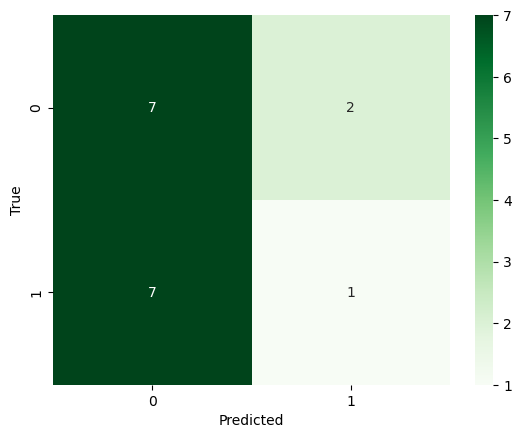

RF

                     Metric     Value
0                  Accuracy  0.470588
1             True Positive  3.000000
2             True Negative  5.000000
3            False Positive  4.000000
4            False Negative  5.000000
5               Sensitivity  0.375000
6               Specificity  0.555556
7    Predictive Value (PPV)  0.428571
8  Negative Predicted Value  0.500000




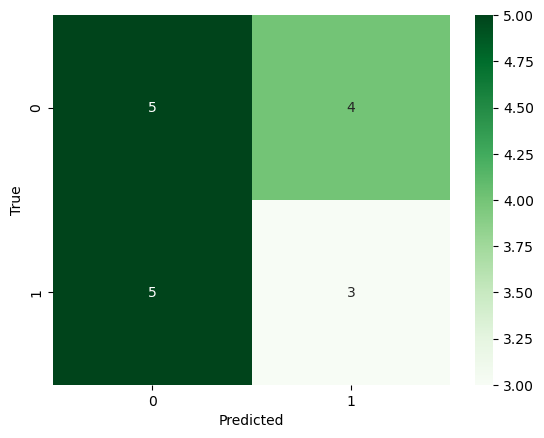

Decision Tree

                     Metric     Value
0                  Accuracy  0.352941
1             True Positive  2.000000
2             True Negative  4.000000
3            False Positive  5.000000
4            False Negative  6.000000
5               Sensitivity  0.250000
6               Specificity  0.444444
7    Predictive Value (PPV)  0.285714
8  Negative Predicted Value  0.400000




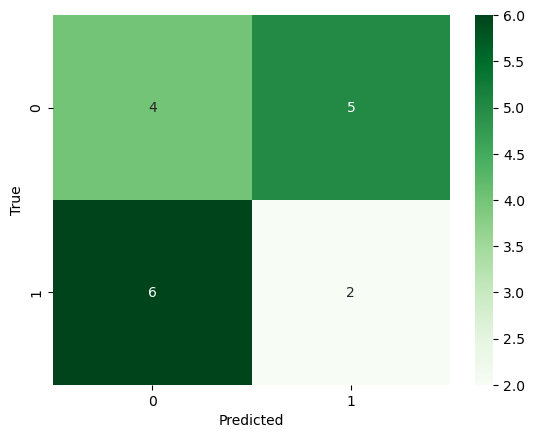

Naive Bayes

                     Metric     Value
0                  Accuracy  0.529412
1             True Positive  3.000000
2             True Negative  6.000000
3            False Positive  3.000000
4            False Negative  5.000000
5               Sensitivity  0.375000
6               Specificity  0.666667
7    Predictive Value (PPV)  0.500000
8  Negative Predicted Value  0.545455




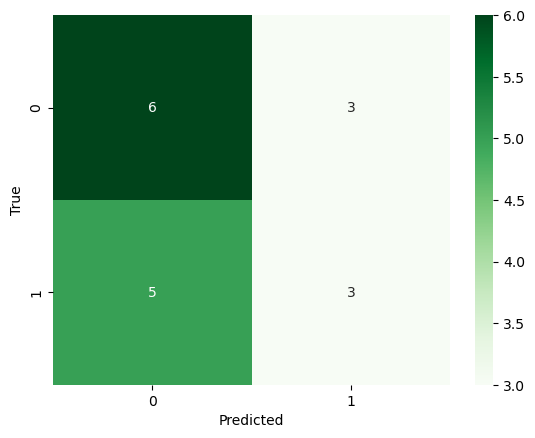

Logistic Regression

                     Metric     Value
0                  Accuracy  0.823529
1             True Positive  6.000000
2             True Negative  8.000000
3            False Positive  1.000000
4            False Negative  2.000000
5               Sensitivity  0.750000
6               Specificity  0.888889
7    Predictive Value (PPV)  0.857143
8  Negative Predicted Value  0.800000




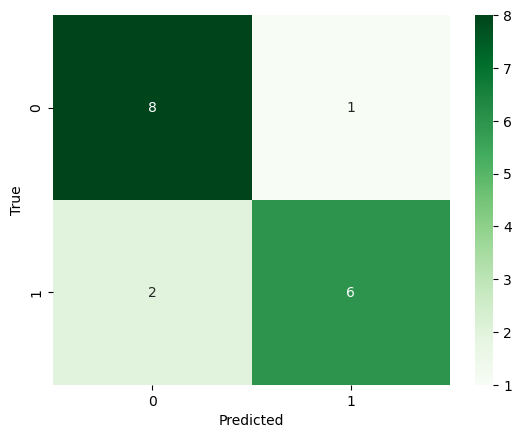

SVM

                     Metric     Value
0                  Accuracy  0.529412
1             True Positive         0
2             True Negative         9
3            False Positive         0
4            False Negative         8
5               Sensitivity       0.0
6               Specificity       1.0
7    Predictive Value (PPV)       NaN
8  Negative Predicted Value  0.529412




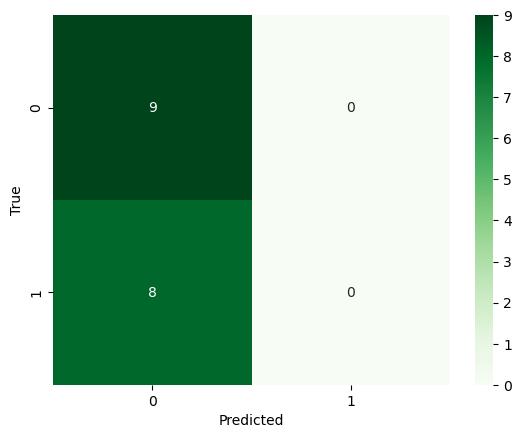

{}

In [68]:
run_ml_algorithms(all_df,'Greens')

KNN

                     Metric     Value
0                  Accuracy  0.375000
1             True Positive  1.000000
2             True Negative  2.000000
3            False Positive  1.000000
4            False Negative  4.000000
5               Sensitivity  0.200000
6               Specificity  0.666667
7    Predictive Value (PPV)  0.500000
8  Negative Predicted Value  0.333333




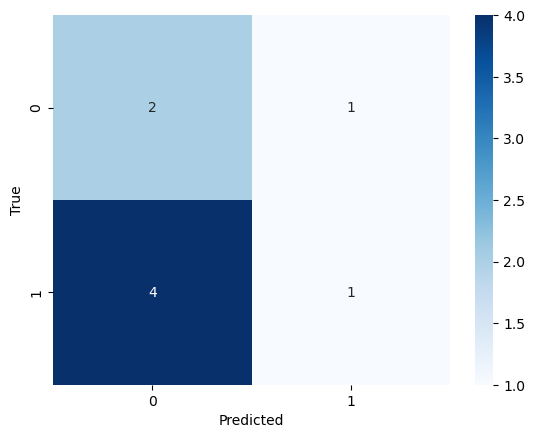

RF

                     Metric     Value
0                  Accuracy  0.500000
1             True Positive  2.000000
2             True Negative  2.000000
3            False Positive  1.000000
4            False Negative  3.000000
5               Sensitivity  0.400000
6               Specificity  0.666667
7    Predictive Value (PPV)  0.666667
8  Negative Predicted Value  0.400000




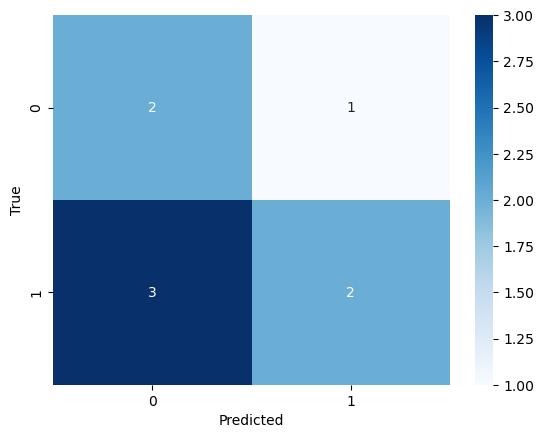

Decision Tree

                     Metric     Value
0                  Accuracy  0.375000
1             True Positive  1.000000
2             True Negative  2.000000
3            False Positive  1.000000
4            False Negative  4.000000
5               Sensitivity  0.200000
6               Specificity  0.666667
7    Predictive Value (PPV)  0.500000
8  Negative Predicted Value  0.333333




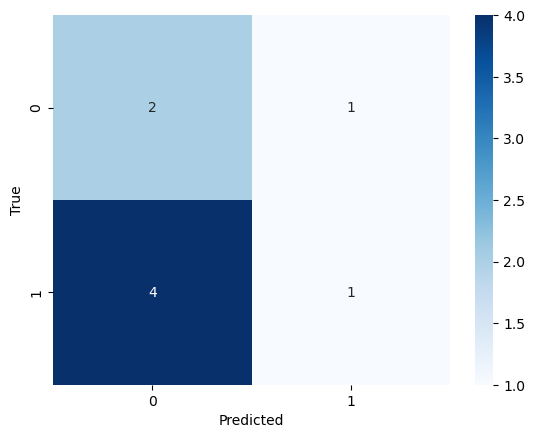

Naive Bayes

                     Metric     Value
0                  Accuracy  0.500000
1             True Positive  2.000000
2             True Negative  2.000000
3            False Positive  1.000000
4            False Negative  3.000000
5               Sensitivity  0.400000
6               Specificity  0.666667
7    Predictive Value (PPV)  0.666667
8  Negative Predicted Value  0.400000




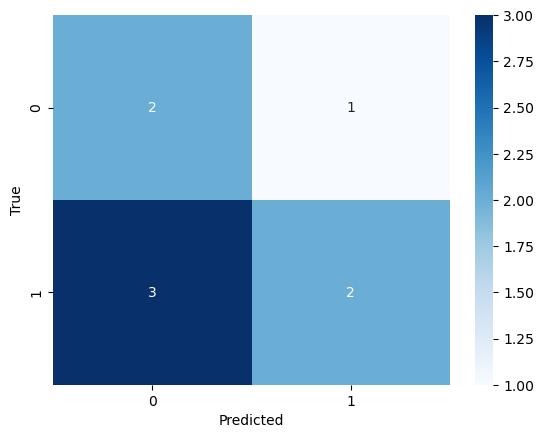

Logistic Regression

                     Metric     Value
0                  Accuracy  0.500000
1             True Positive  1.000000
2             True Negative  3.000000
3            False Positive  0.000000
4            False Negative  4.000000
5               Sensitivity  0.200000
6               Specificity  1.000000
7    Predictive Value (PPV)  1.000000
8  Negative Predicted Value  0.428571




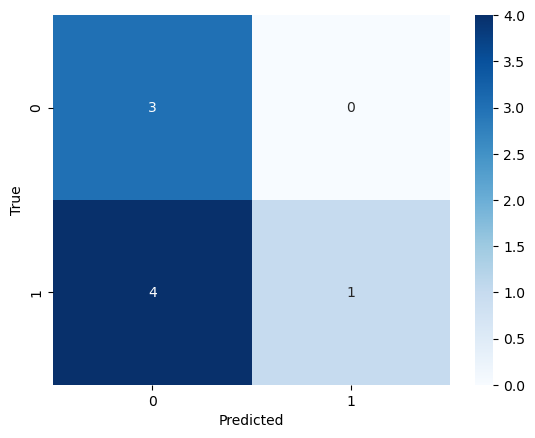

SVM

                     Metric     Value
0                  Accuracy  0.500000
1             True Positive  2.000000
2             True Negative  2.000000
3            False Positive  1.000000
4            False Negative  3.000000
5               Sensitivity  0.400000
6               Specificity  0.666667
7    Predictive Value (PPV)  0.666667
8  Negative Predicted Value  0.400000




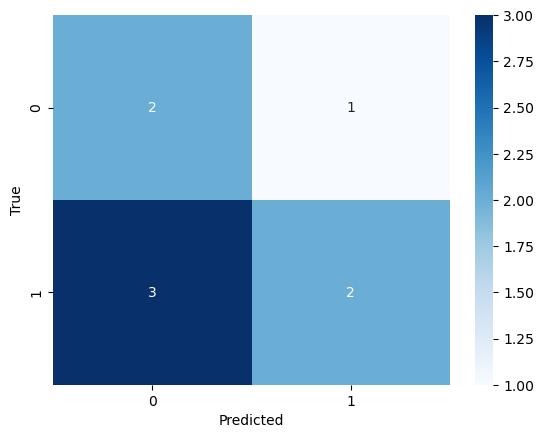

{}

In [69]:
run_ml_algorithms(male_df,'Blues')

KNN

                     Metric     Value
0                  Accuracy  0.666667
1             True Positive  0.000000
2             True Negative  6.000000
3            False Positive  1.000000
4            False Negative  2.000000
5               Sensitivity  0.000000
6               Specificity  0.857143
7    Predictive Value (PPV)  0.000000
8  Negative Predicted Value  0.750000




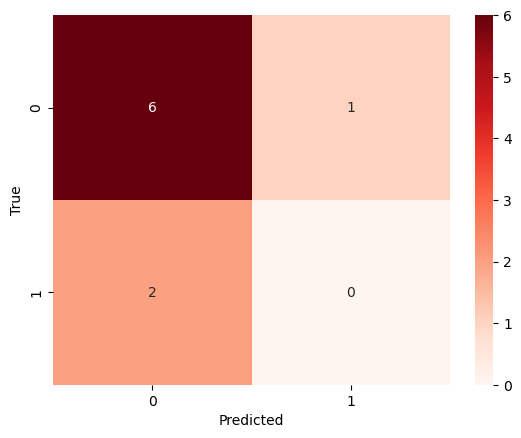

RF

                     Metric     Value
0                  Accuracy  0.666667
1             True Positive  0.000000
2             True Negative  6.000000
3            False Positive  1.000000
4            False Negative  2.000000
5               Sensitivity  0.000000
6               Specificity  0.857143
7    Predictive Value (PPV)  0.000000
8  Negative Predicted Value  0.750000




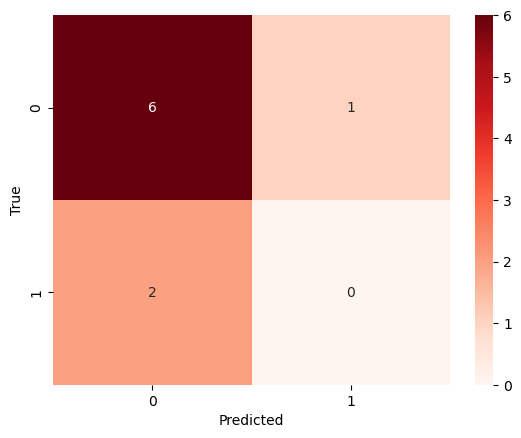

Decision Tree

                     Metric     Value
0                  Accuracy  0.666667
1             True Positive  0.000000
2             True Negative  6.000000
3            False Positive  1.000000
4            False Negative  2.000000
5               Sensitivity  0.000000
6               Specificity  0.857143
7    Predictive Value (PPV)  0.000000
8  Negative Predicted Value  0.750000




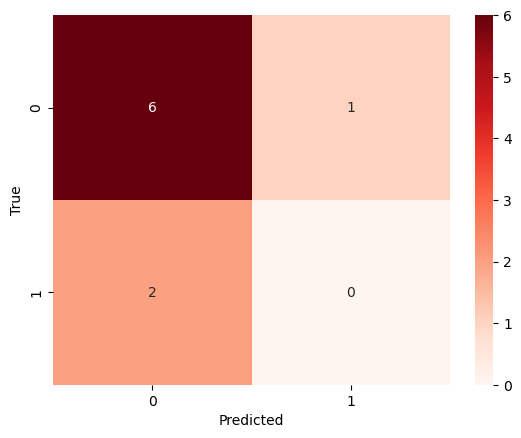

Naive Bayes

                     Metric     Value
0                  Accuracy  0.444444
1             True Positive  0.000000
2             True Negative  4.000000
3            False Positive  3.000000
4            False Negative  2.000000
5               Sensitivity  0.000000
6               Specificity  0.571429
7    Predictive Value (PPV)  0.000000
8  Negative Predicted Value  0.666667




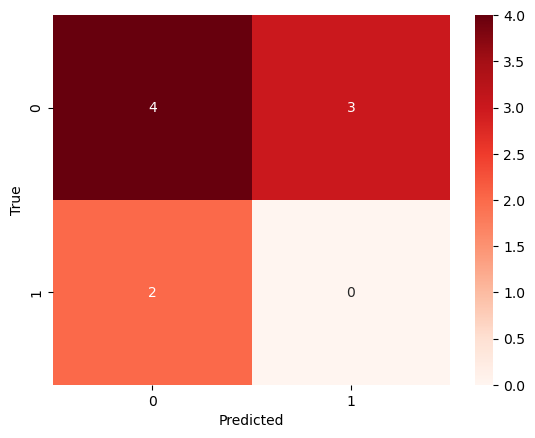

Logistic Regression

                     Metric     Value
0                  Accuracy  0.666667
1             True Positive  0.000000
2             True Negative  6.000000
3            False Positive  1.000000
4            False Negative  2.000000
5               Sensitivity  0.000000
6               Specificity  0.857143
7    Predictive Value (PPV)  0.000000
8  Negative Predicted Value  0.750000




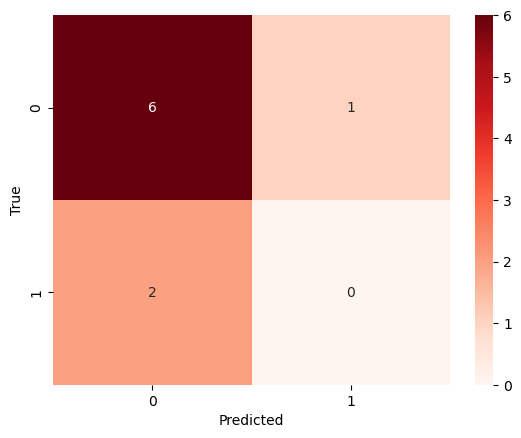

SVM

                     Metric     Value
0                  Accuracy  0.666667
1             True Positive  0.000000
2             True Negative  6.000000
3            False Positive  1.000000
4            False Negative  2.000000
5               Sensitivity  0.000000
6               Specificity  0.857143
7    Predictive Value (PPV)  0.000000
8  Negative Predicted Value  0.750000




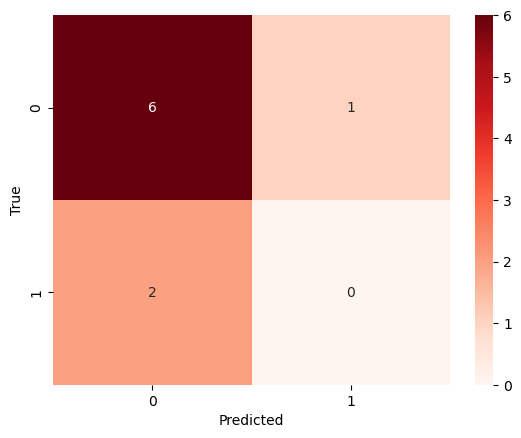

{}

In [70]:
run_ml_algorithms(female_df,'Reds')